# Generative Adversarial Networks
You should build an end-to-end machine learning pipeline using a generative adversarial network model. In particular, you should do the following:
- Load the `mnist` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the [TensorFlow repository](https://www.tensorflow.org/tutorials/generative/dcgan).
- Build an end-to-end machine learning pipeline, including a [generative adversarial network](https://www.tensorflow.org/tutorials/generative/dcgan) model.
- Optimize your pipeline by validating your design decisions.
- Generate new images using your trained generator model and inspect the results.  
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

Importing Required Libraries

In [1]:
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from keras import layers
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

Reading the Dataset

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images.shape

(60000, 28, 28)

##Sampling the Data

In [3]:
SAMPLE_SIZE = 5000
train_images = train_images[:SAMPLE_SIZE]

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = SAMPLE_SIZE
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##Creating the models

Generator Model

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Using (untrained) Generator model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


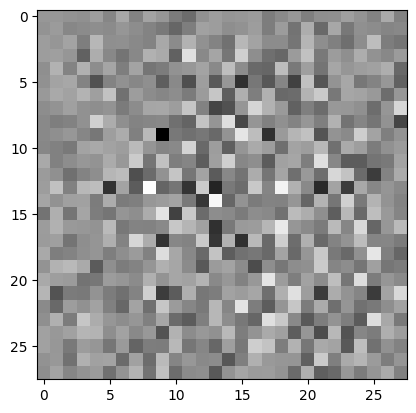

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Discriminator Model

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Using (untrained) Discriminator model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00417741]], shape=(1, 1), dtype=float32)


##Defining the Loss Function

In [9]:
cross_entropy = BinaryCrossentropy(from_logits=True)

Discriminator Loss

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator Loss

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

##Defining Optimizers

In [12]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

##Saving Checkpoints

In [13]:
checkpoint_dir = './training_checkpoints' #checkpoints for the errors or sudden failure
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Defining the Training Loop

In [14]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) #input seed to the model

In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) #defining random noise for the generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) #generating images

      real_output = discriminator(images, training=True) #discriminating the real image
      fake_output = discriminator(generated_images, training=True) #discriminating the fake image generated by the generator

      gen_loss = generator_loss(fake_output) #calculate the loss for the fake image discrimination
      disc_loss = discriminator_loss(real_output, fake_output) #calculate the loss for the discriminator for both images

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) #computes the gradient loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#distribute the gradient loss (weights)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [17]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Training the Model

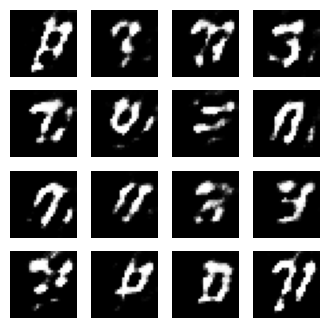

In [19]:
train(train_dataset, EPOCHS)

Restoring the Checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))